In [15]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

import pickle
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## NES

参考原文，实现NES黑盒对抗样本攻击

In [16]:
from Week567_General_Code_Question import LeNet5, nes, evaluate
from Week567_General_Code_Question import visualize_adv

### 目标模型加载

注意，请将week5保存的lenet5.pt迁移到/model路径下

In [17]:
model = LeNet5()
### 请将Week5保存的lenet5.pt迁移到/model路径下
model.load_state_dict(torch.load('model/lenet5.pt'))
model.eval()

criterion = nn.CrossEntropyLoss()

C:\Users\w2213\AppData\Local\Temp\ipykernel_34108\4078520847.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/lenet5.pt'))


### 读入待攻击的样本

注意，需导入week6的新版本Week567_img_label.pkl

In [18]:
with open('data/Week567_img_label.pkl', 'rb') as f:
    data = pickle.load(f)
    imgs, labels = data['img'], data['label']

### 实现基于NES梯度估计的攻击

- 请在Week567_General_Code_Question.py的`nes(imgs, epsilon, model, labels, sigma, n)`函数中实现NES黑盒梯度估计
  - 核心思想：根据梯度定义，有$\nabla_x f(x) = \frac{f(x + \sigma) - f(x - \sigma)}{2\sigma}$；
  - 给定模型$P$，单个样本$x \in \mathbb{R}^{N}$，正确标签$y$，采样次数$n$，搜索方差$\sigma$，梯度$\nabla_x P(y|x)$可以通过如下方法估计：
    1. 采样噪声$u_i \gets \mathcal{N}(0_N, I_{N \cdot N})$
    2. 估计梯度$g_i \gets \frac{P(y|x + \sigma \cdot u_i) - P(x - \sigma \cdot u_i)}{2 \sigma}$
    3. $n$次采样求均值，$\nabla_x P(y|x) \approx \frac{1}{n} \sum_{i=1}^{n} g_i$

- 建议使用的API：
  - torch.randn [Link](https://pytorch.org/docs/stable/generated/torch.randn.html)
    - 采样随机高斯噪声

In [19]:
epsilon = 0.35 # 0.2
sigma = 0.001
n = 50
adv_xs = nes(imgs, epsilon, model, labels, sigma, n)

### 评测攻击效果

- 评估模型对样本adv_xs的预测结果与真实标签labels的匹配率。该匹配率越低，则攻击效果越好。

In [20]:
pred_label = evaluate(adv_xs, labels, model)

match rate: 0.2


### 对抗样本可视化

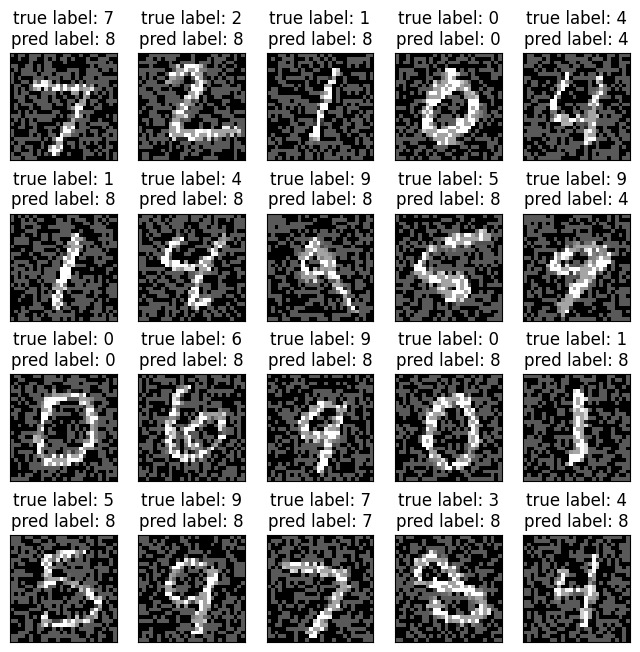

In [21]:
adv_imgs = adv_xs.reshape_as(imgs)
visualize_adv(adv_imgs, labels, pred_label)